# GMVAE Evaluation

This section would focus on solving most of the questions that are regarding Q1. <br>

In [19]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision import transforms
from torch.utils.data import DataLoader
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 12]

from utils import tools 
from utils.models.gmvae import GMVAE
from utils.train import train


# Import the necessary modules
from utils import CXReader, DfReader

### Assign paths here

In [2]:
#Path to assign tests (copy path directly)
work_path = r"D:\Python_Projects\CS236-Final-Proj\src"
device = "cpu"
#Set the path to this working directory
os.chdir(work_path)
print(os.getcwd())

# Create the data path
data_path = os.path.join(os.getcwd(), os.pardir, "data")

D:\Python_Projects\CS236-Final-Proj\src


### Set the dataframes

In [3]:
#Create a dataframe compiler
df_compiler = DfReader()

#set the path and retrieve the dataframes
df_compiler.set_folder_path(data_path)

#Get the dataframe holder and names
dfs_holder, dfs_names = df_compiler.get_dfs()

100%|█████████▉| 112121/112124 [00:00<00:00, 237253.81it/s]

The file: miccai2023_nih-cxr-lt_labels_test.csv has been retrieved


100%|██████████| 112124/112124 [00:01<00:00, 79097.63it/s] 

The file: miccai2023_nih-cxr-lt_labels_train.csv has been retrieved
The file: miccai2023_nih-cxr-lt_labels_val.csv has been retrieved


### Set the data with all required transformation

In [4]:
# Define mean and std for normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Define a transformation for converting and normalizing images
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel grayscale
    transforms.Resize((256, 256)),  # Resize to 256x256
    transforms.CenterCrop((224, 224)),  # Center crop to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean, std)  # Apply mean and std normalization
])
#Create datasets and dataloaders, with batch size of 16, and shuffle true, and num workers = 4
test_dataset = CXReader(data_path=data_path, dataframe=dfs_holder[0], transform=transform, device=device)
train_dataset = CXReader(data_path=data_path, dataframe=dfs_holder[1], transform=transform, device=device)
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

### Set the test images with all required labels

In [5]:
#Create a labeled_subset tuple by iterating through 100 values of test dataset
test_images = []
test_labels = []
print("Loading labeled subset...")
for i in range(100):
    #Sampled images from train to see single shape
    test_image, test_label = test_dataset[i]
    test_images.append(test_image)
    test_labels.append(test_label)

# Convert the list of tensors to a tensor of tensors
test_images= torch.stack(test_images, dim=0)
test_labels= torch.stack(test_labels, dim=0)
labeled_subset = (test_images, test_labels)
print("Getting labeled subset")

Loading labeled subset...


Getting labeled subset


In [14]:
#Z space like run gmvae
z = 300
k = 50
run = 0
global_num = 2000
loss = "mse"
name = "gmvaedec3" + loss

layout = [
    ('model={:s}',  name),
    ('z={:02d}',  z),
    ('k={:03d}',  k),
    ('run={:04d}', run)
]
model_name = '_'.join([t.format(v) for (t, v) in layout])
print('Model name:', model_name)

#modelt type
model_type = "CXR14_V3"

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gmvae = GMVAE(nn=model_type,z_dim=z, k=k, name=model_name, loss_type=loss).to(device)

tools.load_model_by_name(gmvae, global_step=global_num)

Model name: model=gmvaedec3mse_z=300_k=050_run=0000
loss used mse
Loaded from D:\Python_Projects\CS236-Final-Proj\src\checkpoints\model=gmvaedec3mse_z=300_k=050_run=0000\model-02000.pt


In [15]:
tools.evaluate_lower_bound(gmvae, labeled_subset, run_iwae=False)

********************************************************************************
LOG-LIKELIHOOD LOWER BOUNDS ON TEST SUBSET
********************************************************************************
estimate of metrics:...1
estimate of metrics:...2
NELBO: 6.580920219421387. KL: 0.13124358654022217. Rec: 6.449676513671875


### Create a code that plots an image

In [16]:
def show_image(image, name_img: str):
    """
    Instance method that would plot an
    image to see if the dataset is properly set.
    """
    f, ax1 = plt.subplots(1, 1)
    ax1.set_title('Desired image ' + name_img)
    ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

torch.Size([3, 224, 224])


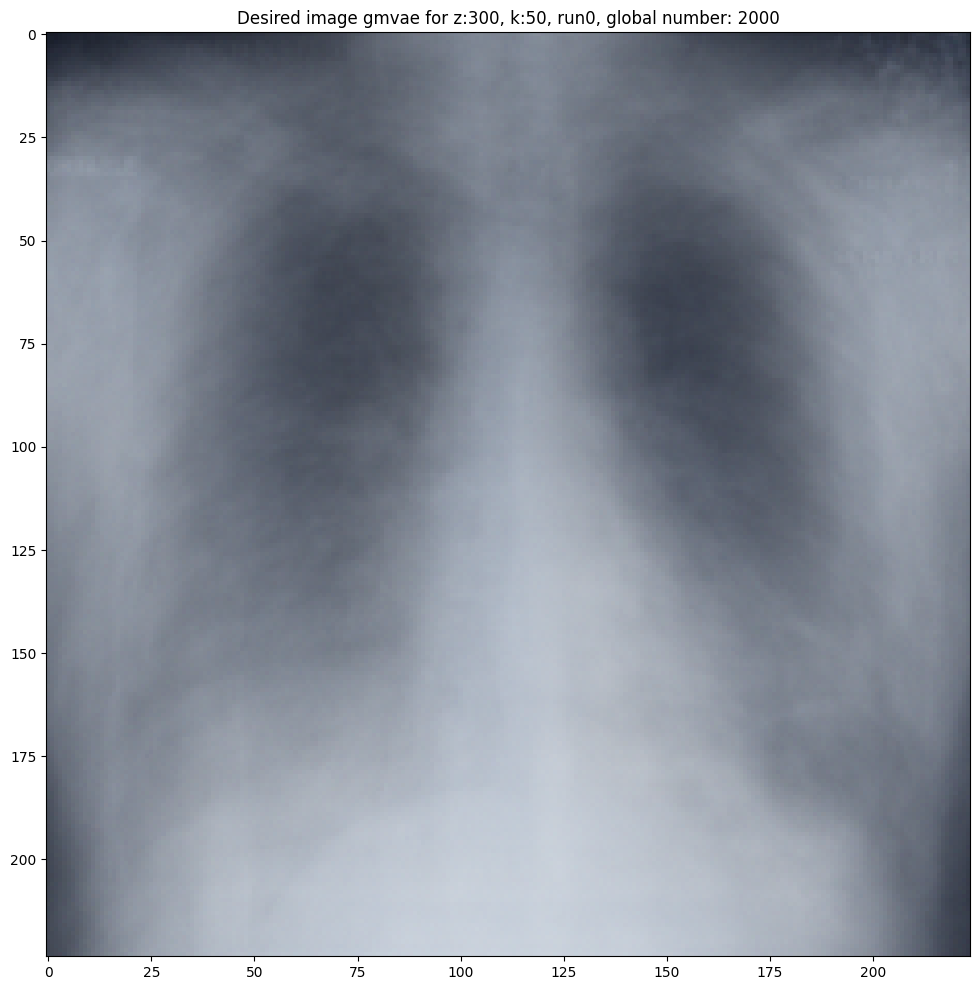

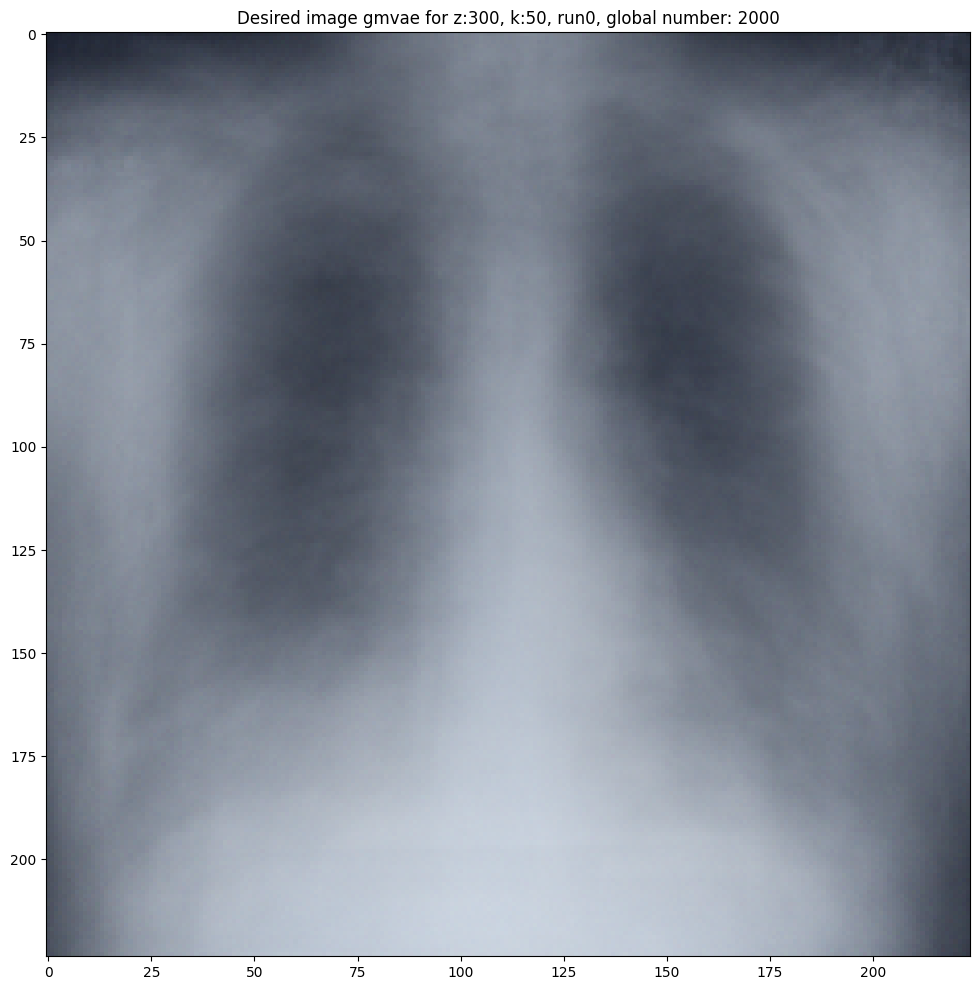

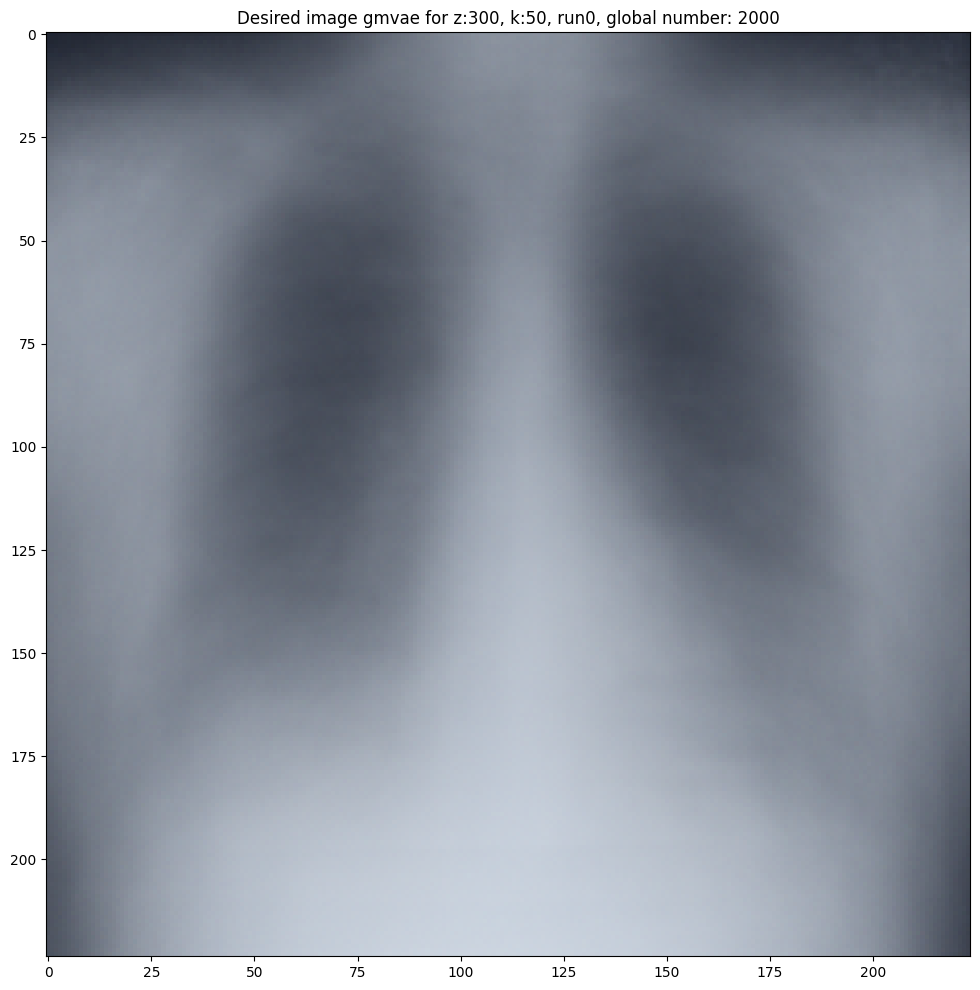

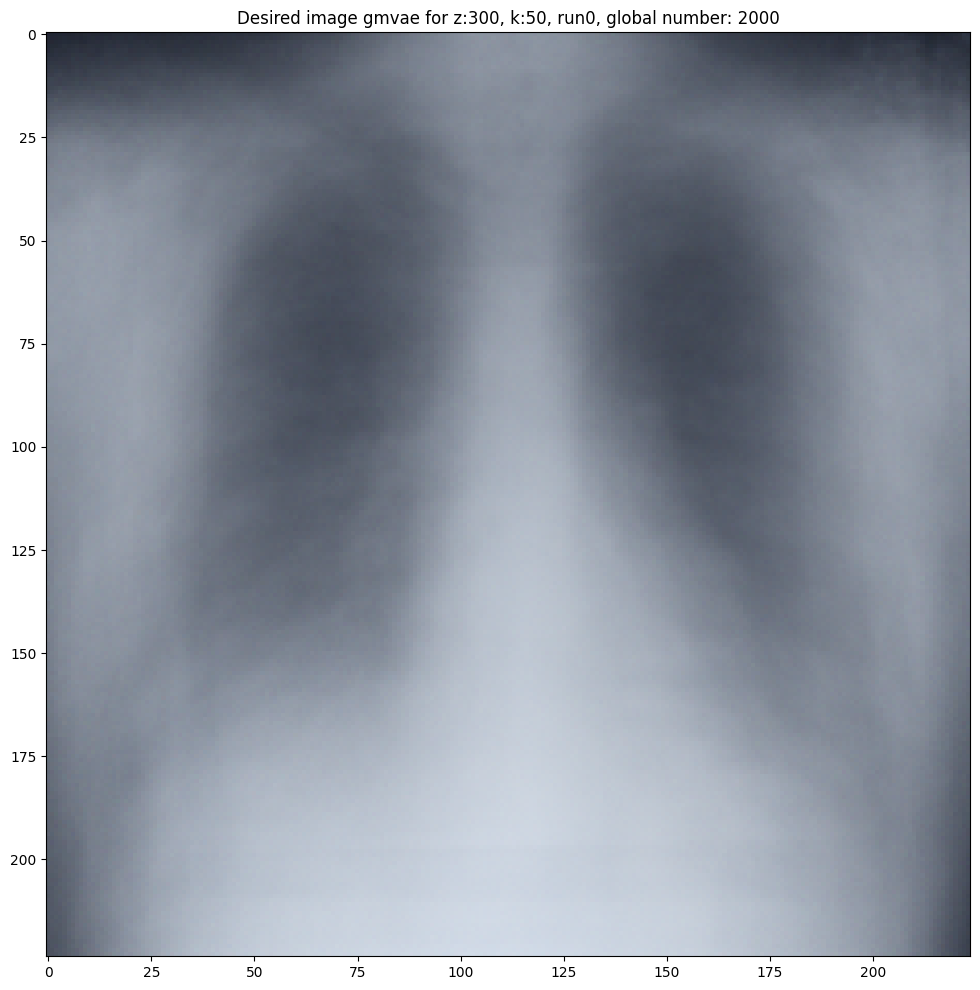

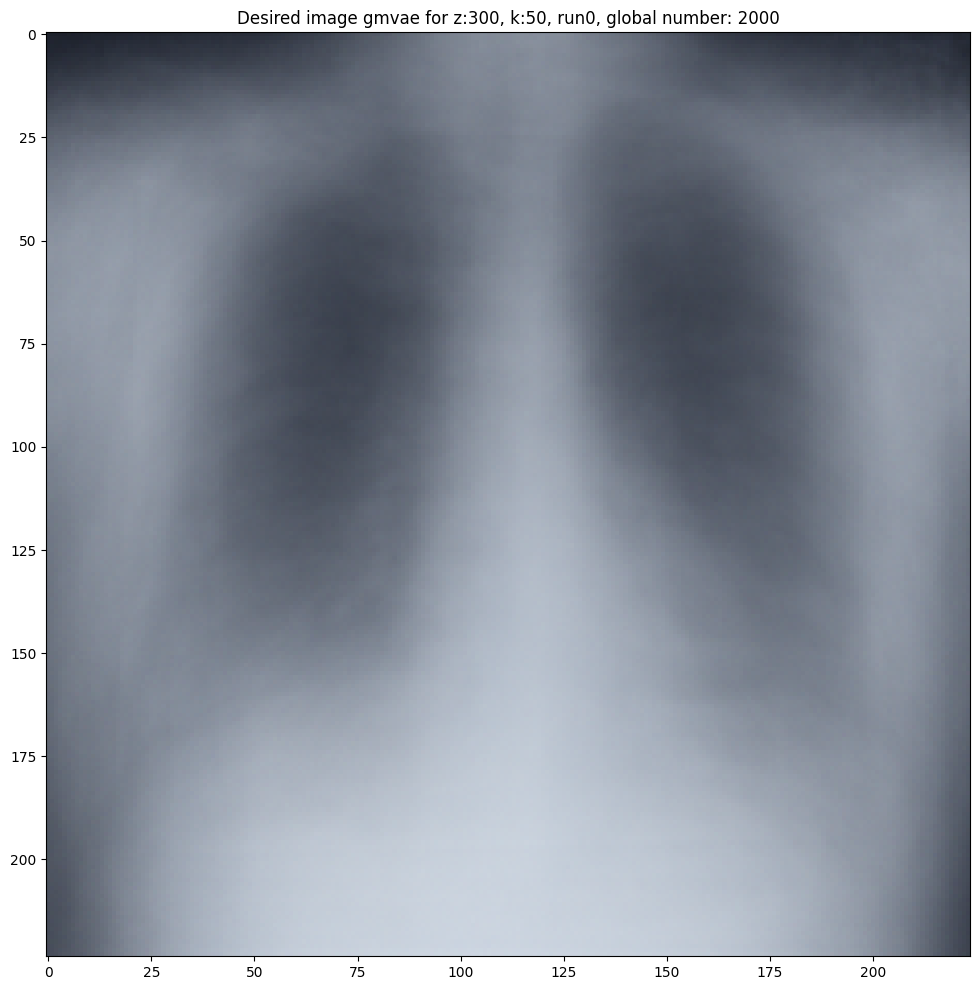

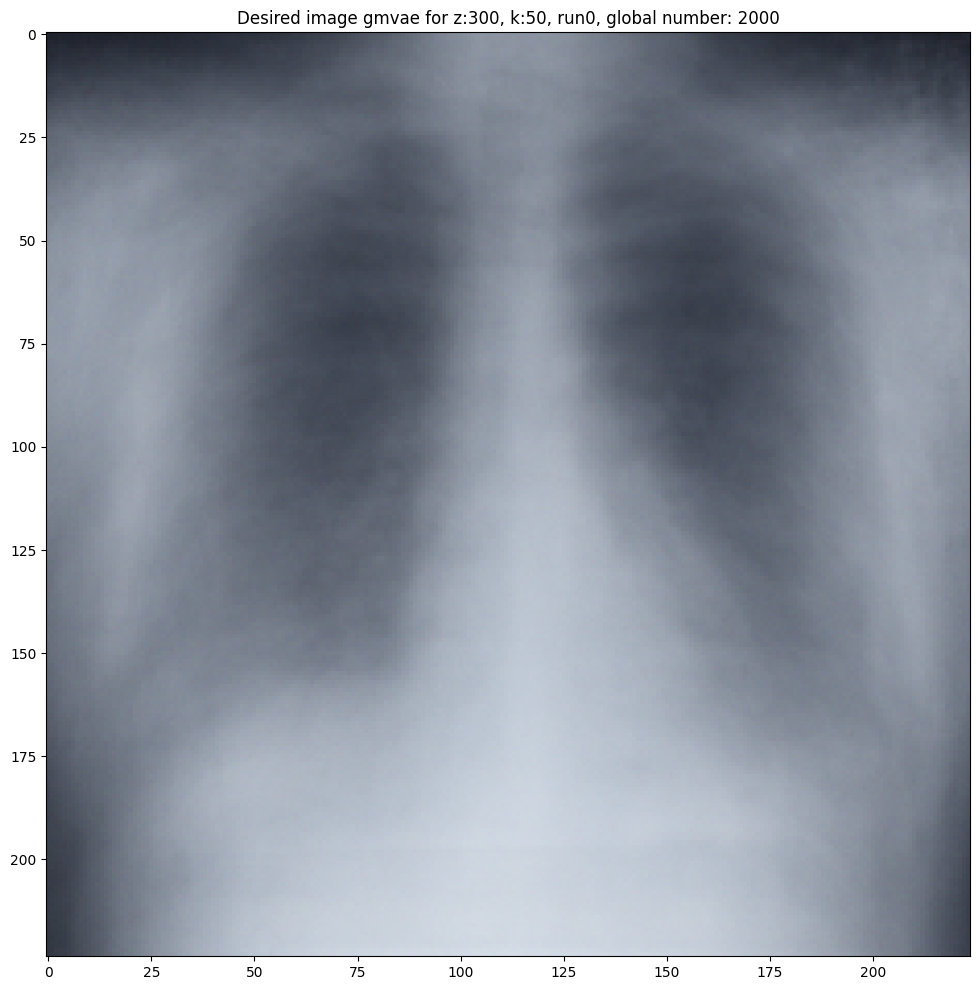

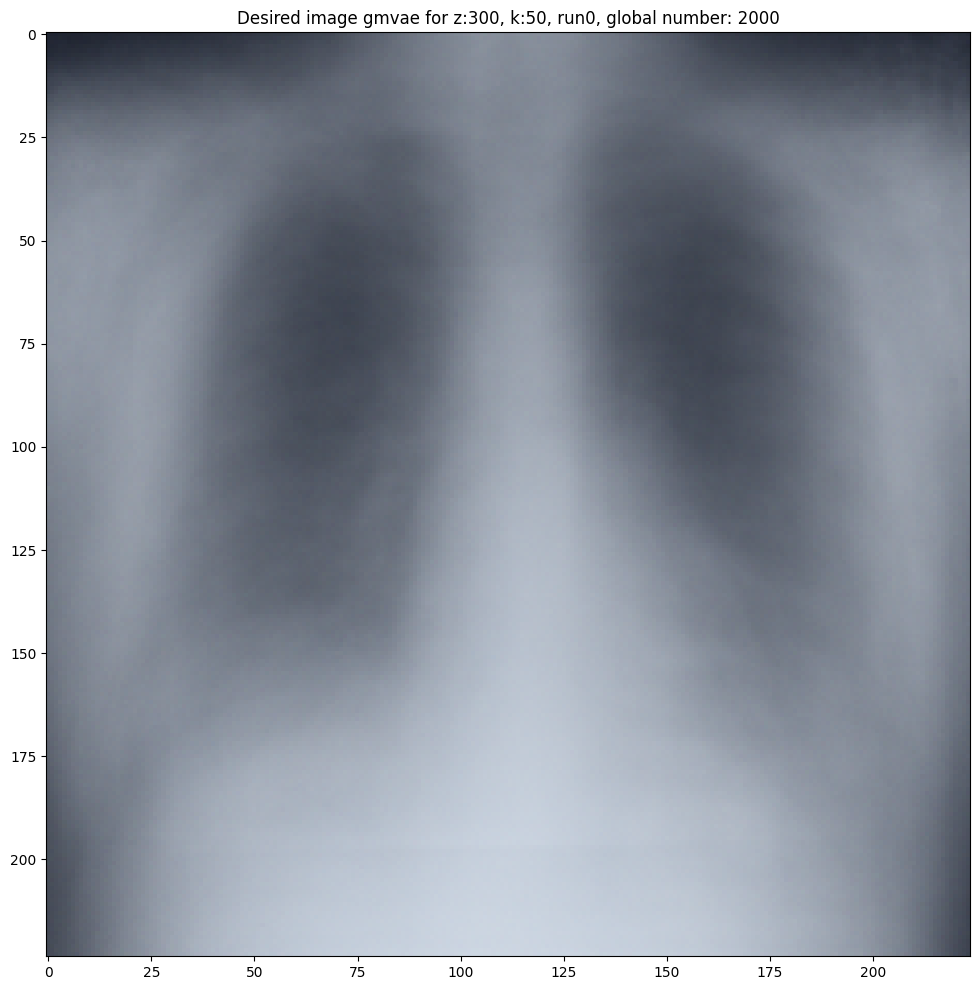

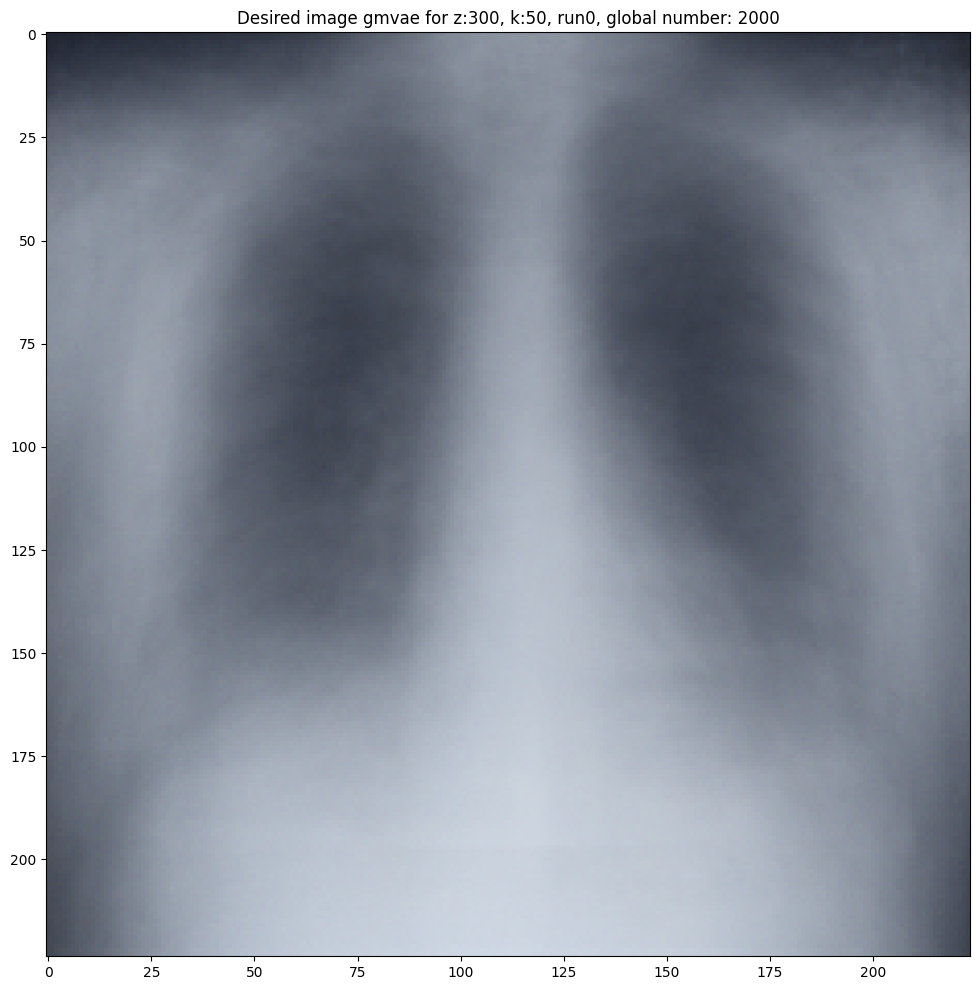

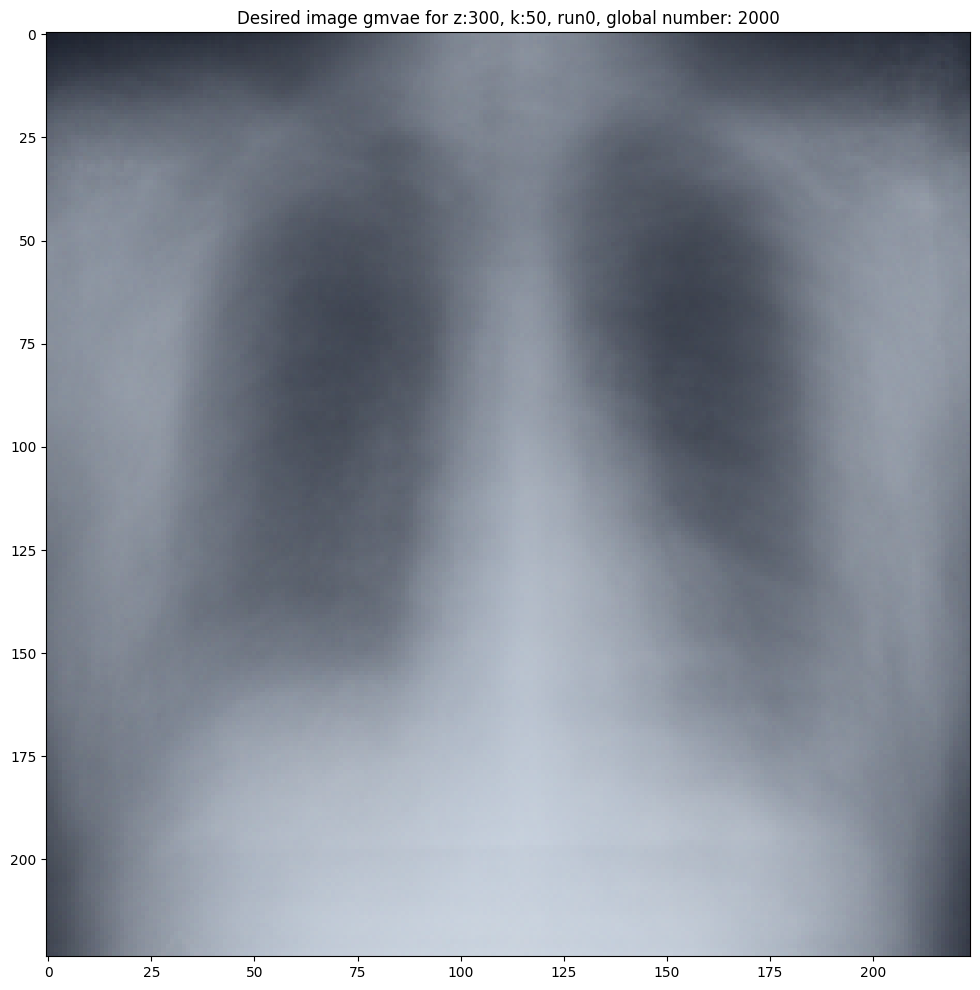

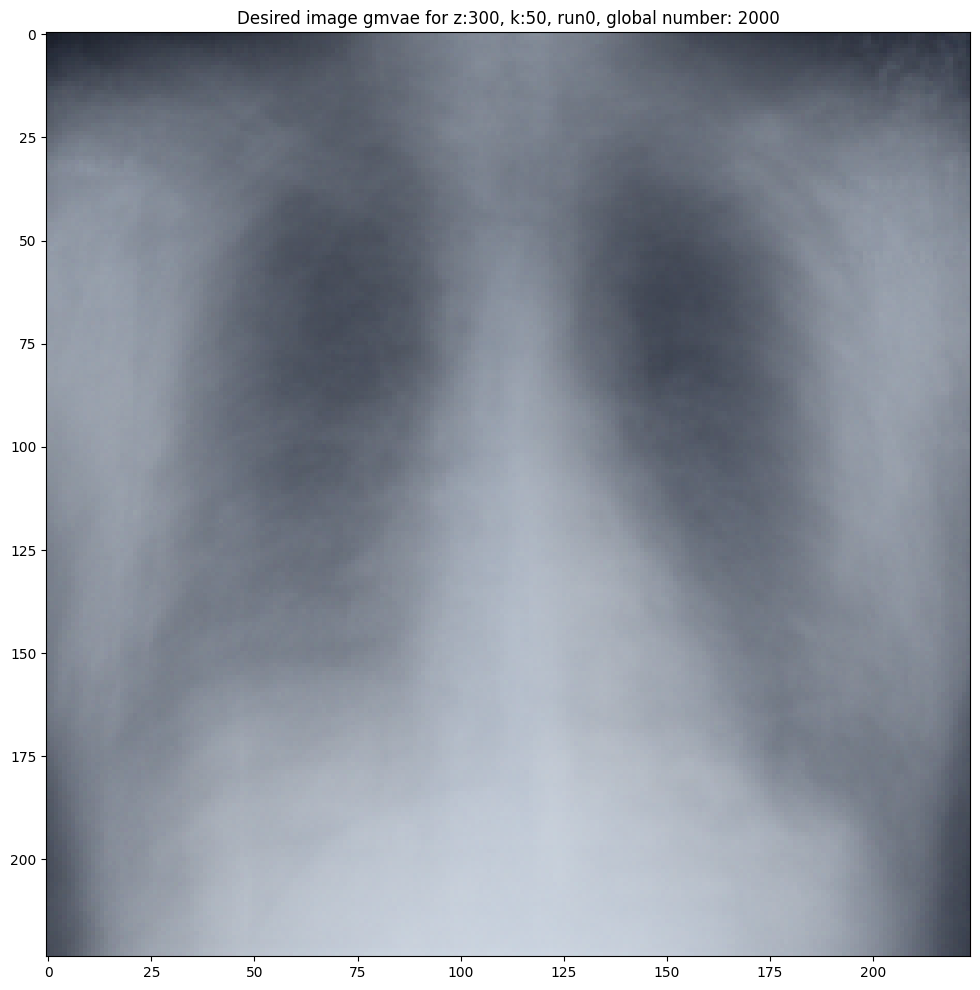

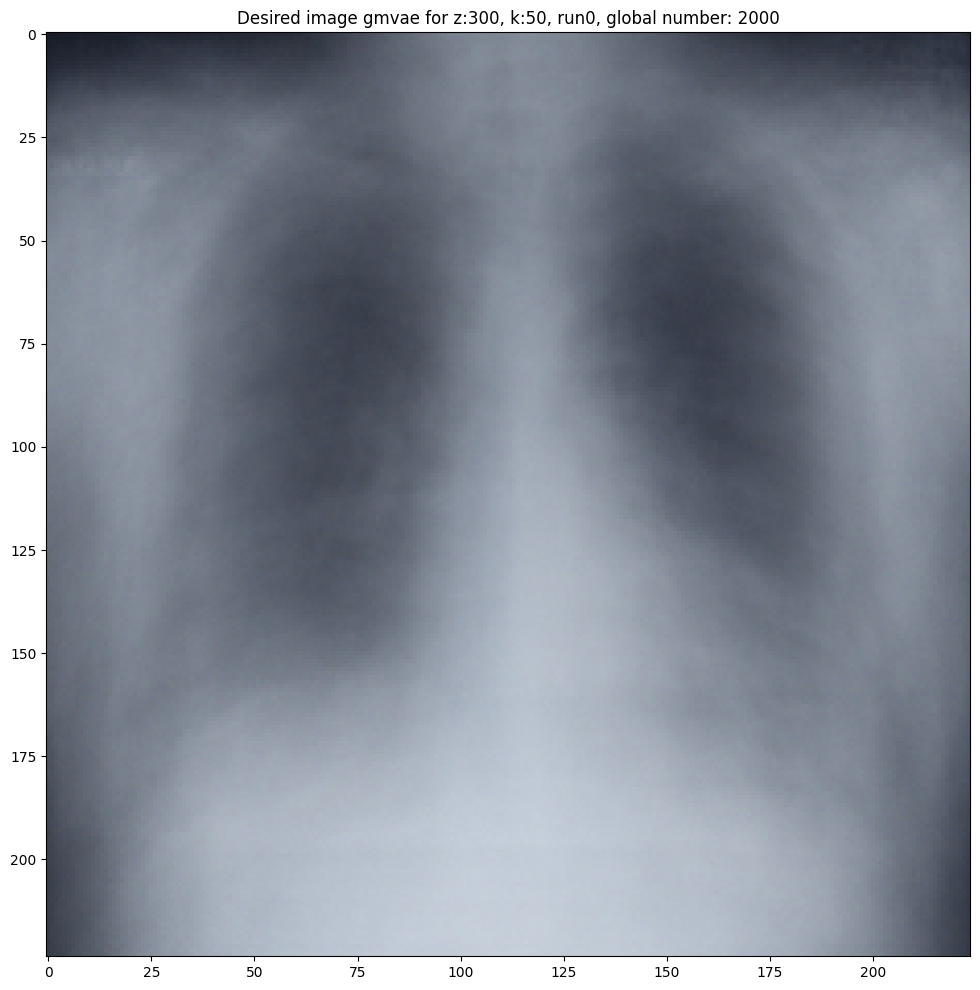

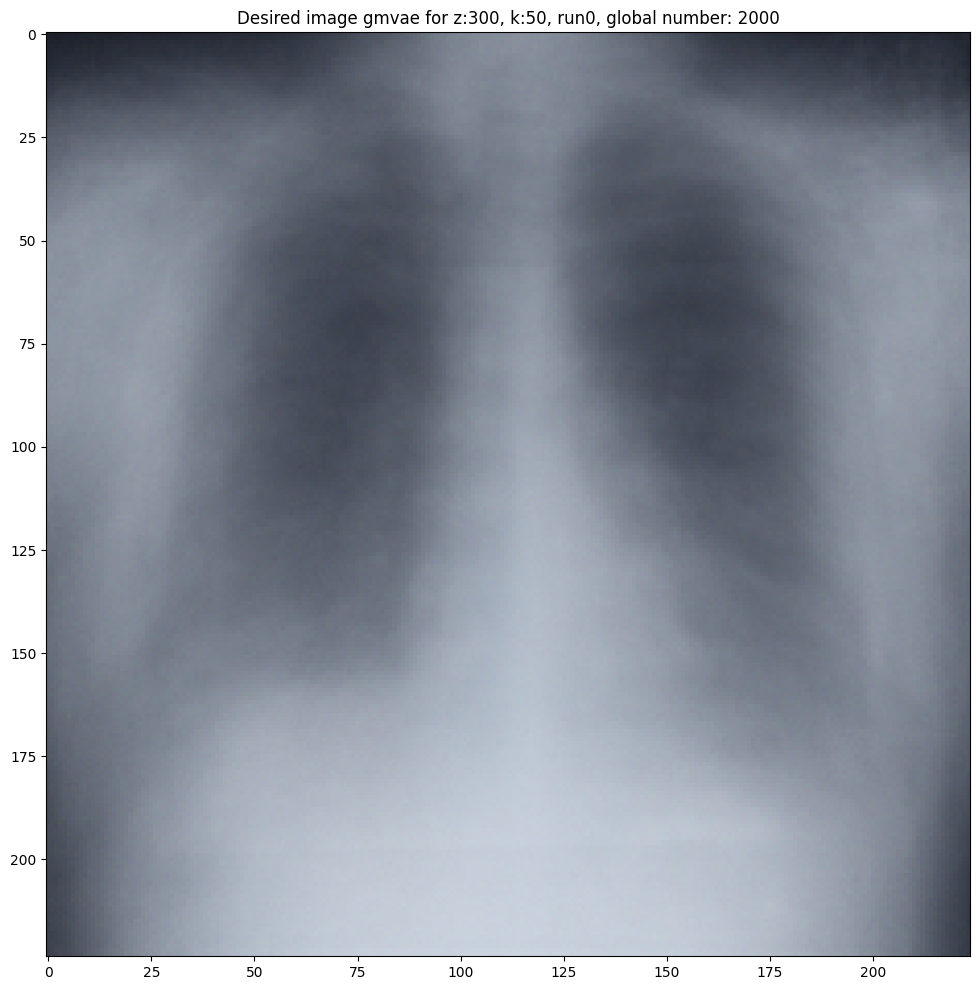

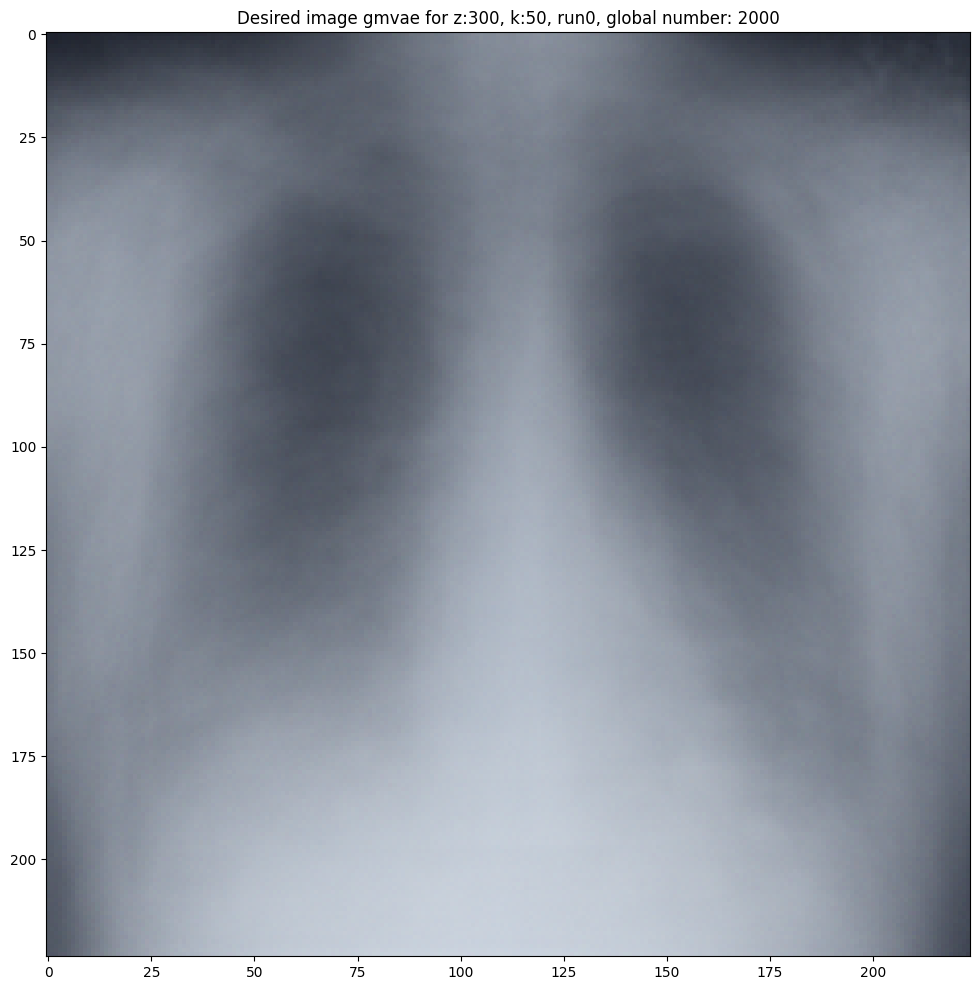

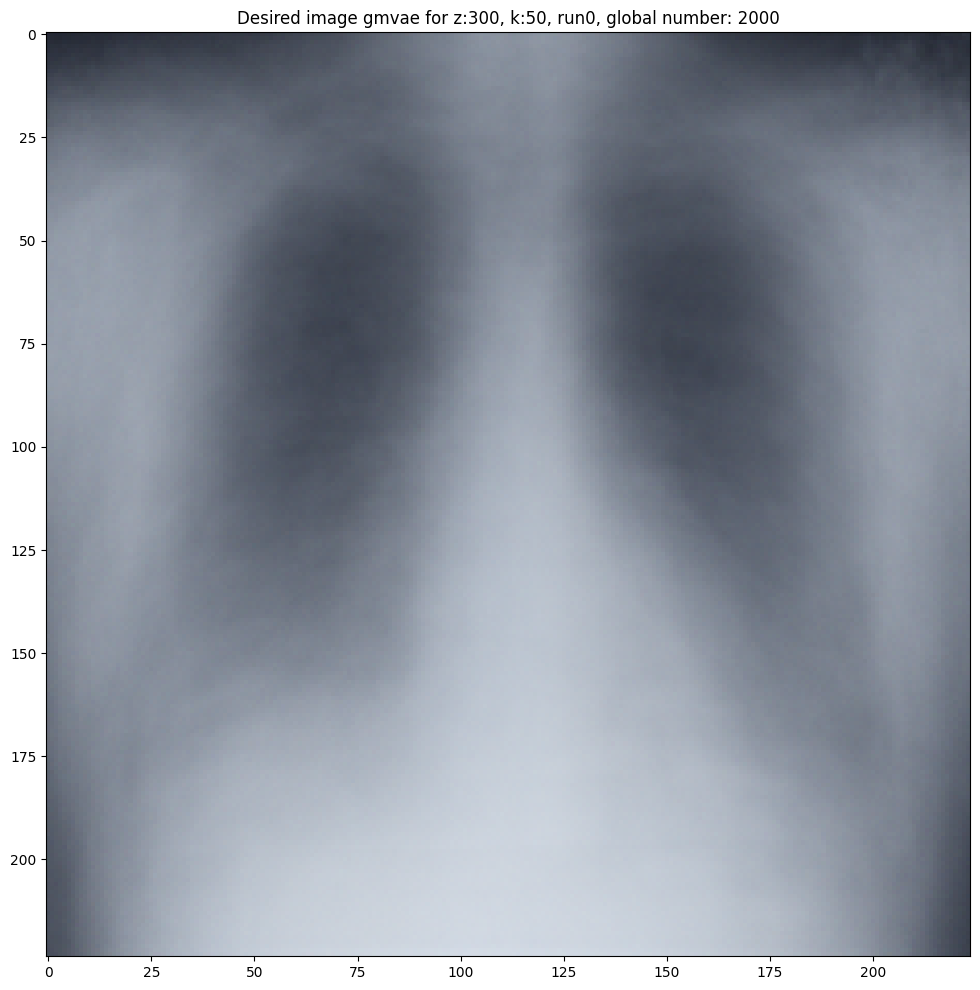

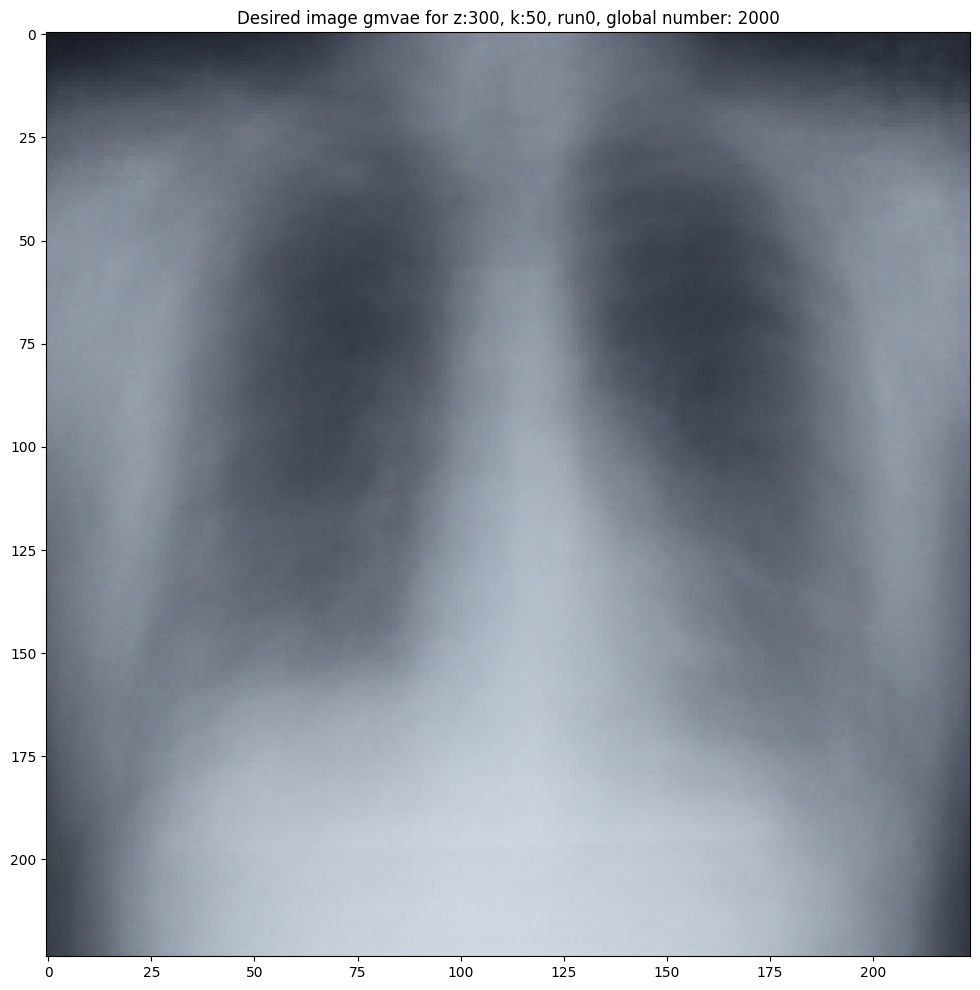

In [17]:
#Batch number
batch_num = 15

samples = gmvae.sample_x(batch_num).reshape(batch_num,3,224,224).cpu()

#grid = make_grid(samples, nrow=20)
#imshow(grid.permute(1,2,0))
print(samples[2].shape)
for idx in range(batch_num):
    show_image(samples[idx].detach(), f"gmvae for z:{z}, k:{k}, run{run}, global number: {global_num}")

### Now that we have the images.
The last thing to do is to plot the neblo, reconstruction loss, and KL divergence between the specific desired <br>
models, nevertherless. For one of them, a concatnation musst be done.

In [36]:
#Model name
model_1_name = "model=gmvaedec3bce_z=300_k=050"

#Model runs
run_1 = "600"
run_2 = "1400"

#Load the necessary files for specific .npy files.
model_1_path_part1 = model_1_name + "_run=0000"
model_1_path_part2 = model_1_name + "_run=0600"


In [62]:
#Model name
model_2_name = "model=gmvaedec3mse_z=300_k=050"

#Model runs
run_22 = "2000"

#Load the necessary files for specific .npy files.
model_2_path = model_2_name + "_run=0000"

In [37]:
def load_files(part_name:str, run:str):
    """
    Function that would load the rec, loss, and KL divergence
    of a specific run
    """
    #Depending on the length of run, create a string with apended missing zeros
    while len(run) < 5:
        run = '0' + run

    #Create a path to part desired
    src_path = os.path.join(os.getcwd(), os.pardir, "src")

    # Load the rec loss
    rec = np.load(os.path.join(src_path, "checkpoints", part_name, "rec-" +run + ".pt.npy"), allow_pickle=True)
    loss = np.load(os.path.join(src_path, "checkpoints", part_name,"loss-"+run+".pt.npy"), allow_pickle=True)
    kl = np.load(os.path.join(src_path, "checkpoints", part_name,"kl-"+run+".pt.npy"), allow_pickle=True)

    return rec, loss, kl


In [57]:
def plot_arrays(rec, loss, kl, model_name):
    """
    Plots the necessary graphs to obtain the reconstruction loss,
    nelbo loss, and kl divergence
    """

    plt.figure()
    plt.plot(loss, color = "r", label = "Nelbo")
    plt.legend(loc = "upper right")
    plt.xlabel("Training epochs")
    plt.ylabel("loss")
    plt.suptitle("Total nelbo loss for " + model_name, fontsize=28)

    plt.figure()
    plt.plot(rec, color = "blue", label = "Reconstruction loss")
    plt.legend(loc = "upper right")
    plt.xlabel("Training epochs")
    plt.ylabel("rec")
    plt.suptitle("Total reconstruction loss for " + model_name, fontsize=28)

    plt.figure()
    plt.plot(kl, color = "g", label = "KL divergence")
    plt.legend(loc = "upper right")
    plt.xlabel("Training epochs")
    plt.ylabel("kl")
    plt.suptitle("Total kl divergence for " + model_name, fontsize=28)
    plt.show()

In [58]:
#Addition of rec loss and kl
rec_1_1, loss_1_1, kl_1_1 = load_files(model_1_path_part1, run_1)
rec_1_2, loss_1_2, kl_1_2 = load_files(model_1_path_part2, run_2)

#Concatanate the necessary arrays
rec_1 = np.concatenate((rec_1_1, rec_1_2))
loss_1 = np.concatenate((loss_1_1, loss_1_2))
kl_1 = np.concatenate((kl_1_1, kl_1_2))

In [63]:
#Addition of rec loss and kl
rec_2, loss_2, kl_2 = load_files(model_2_path, run_22)

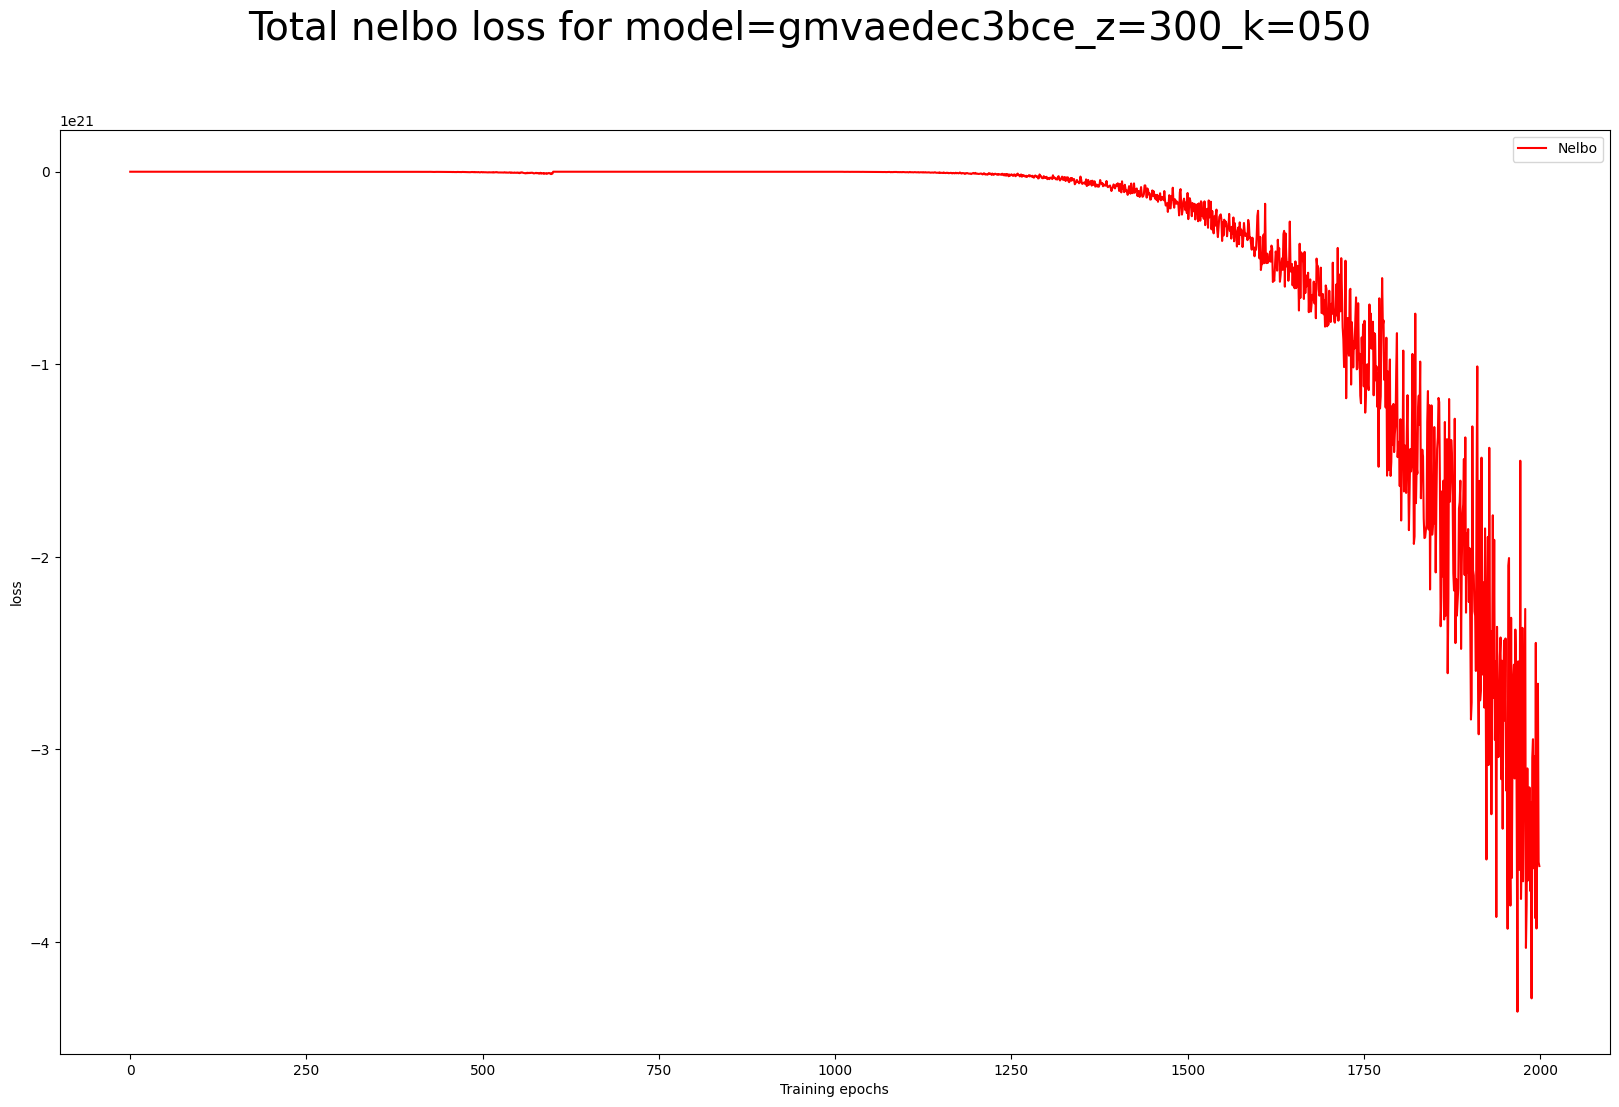

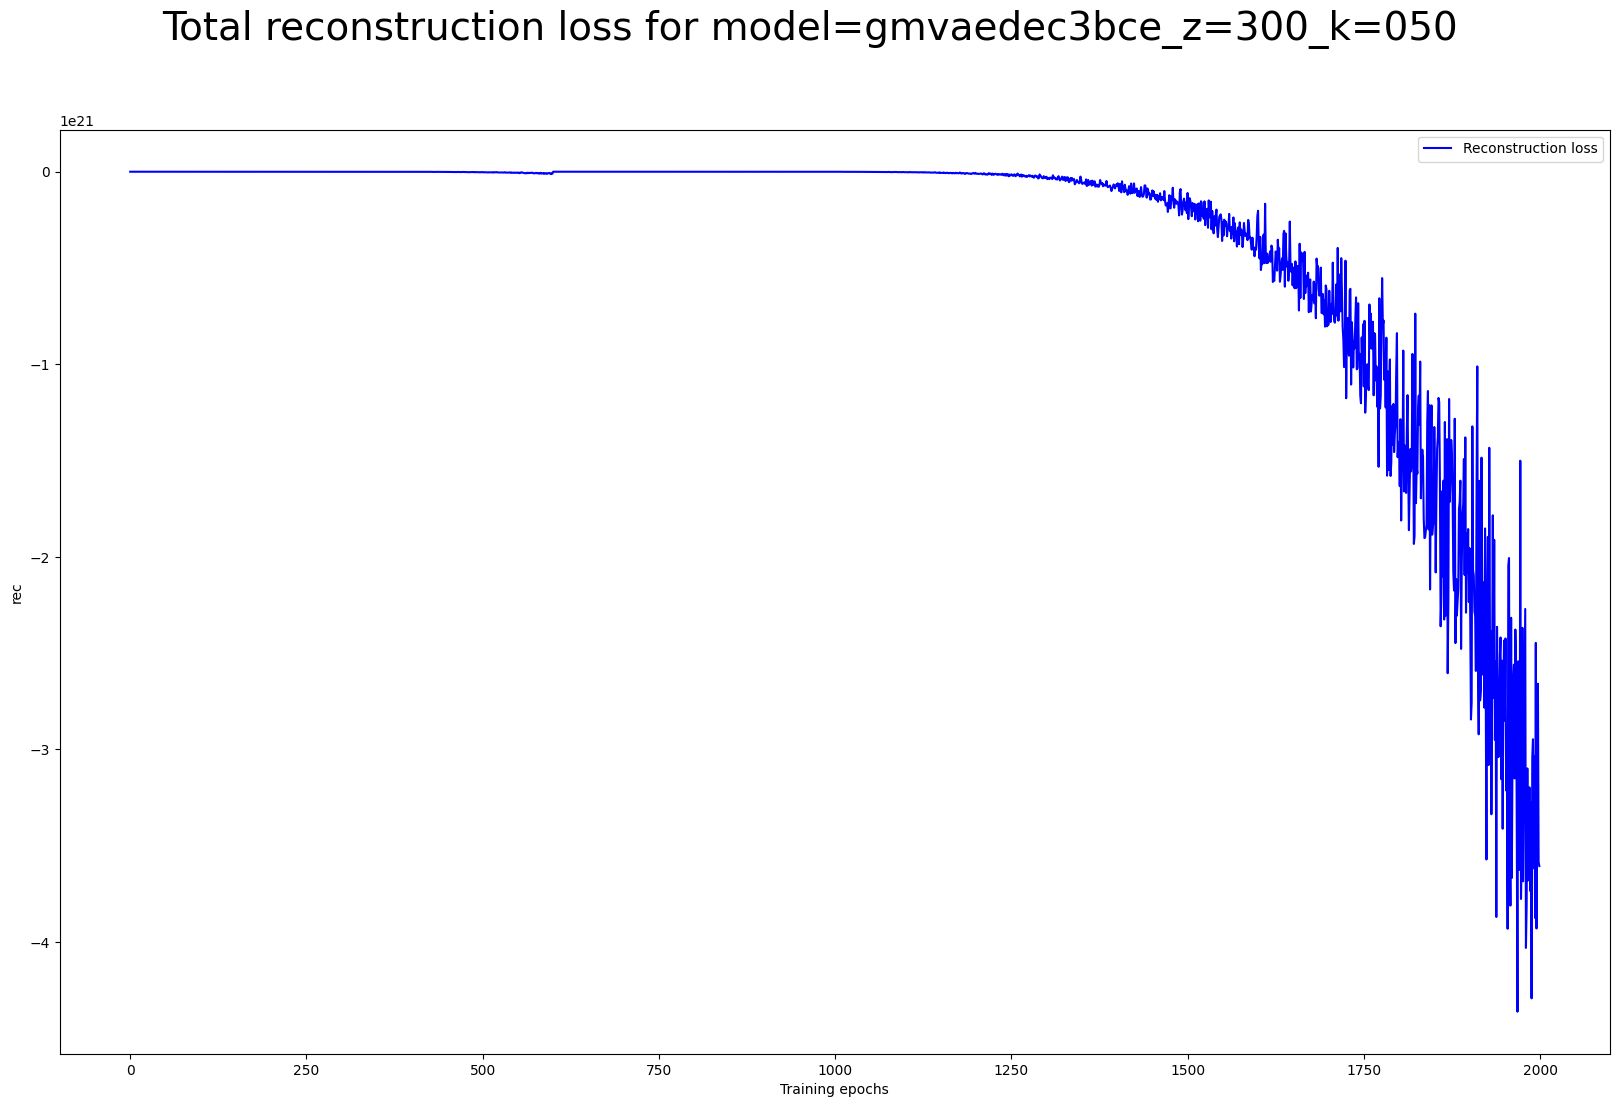

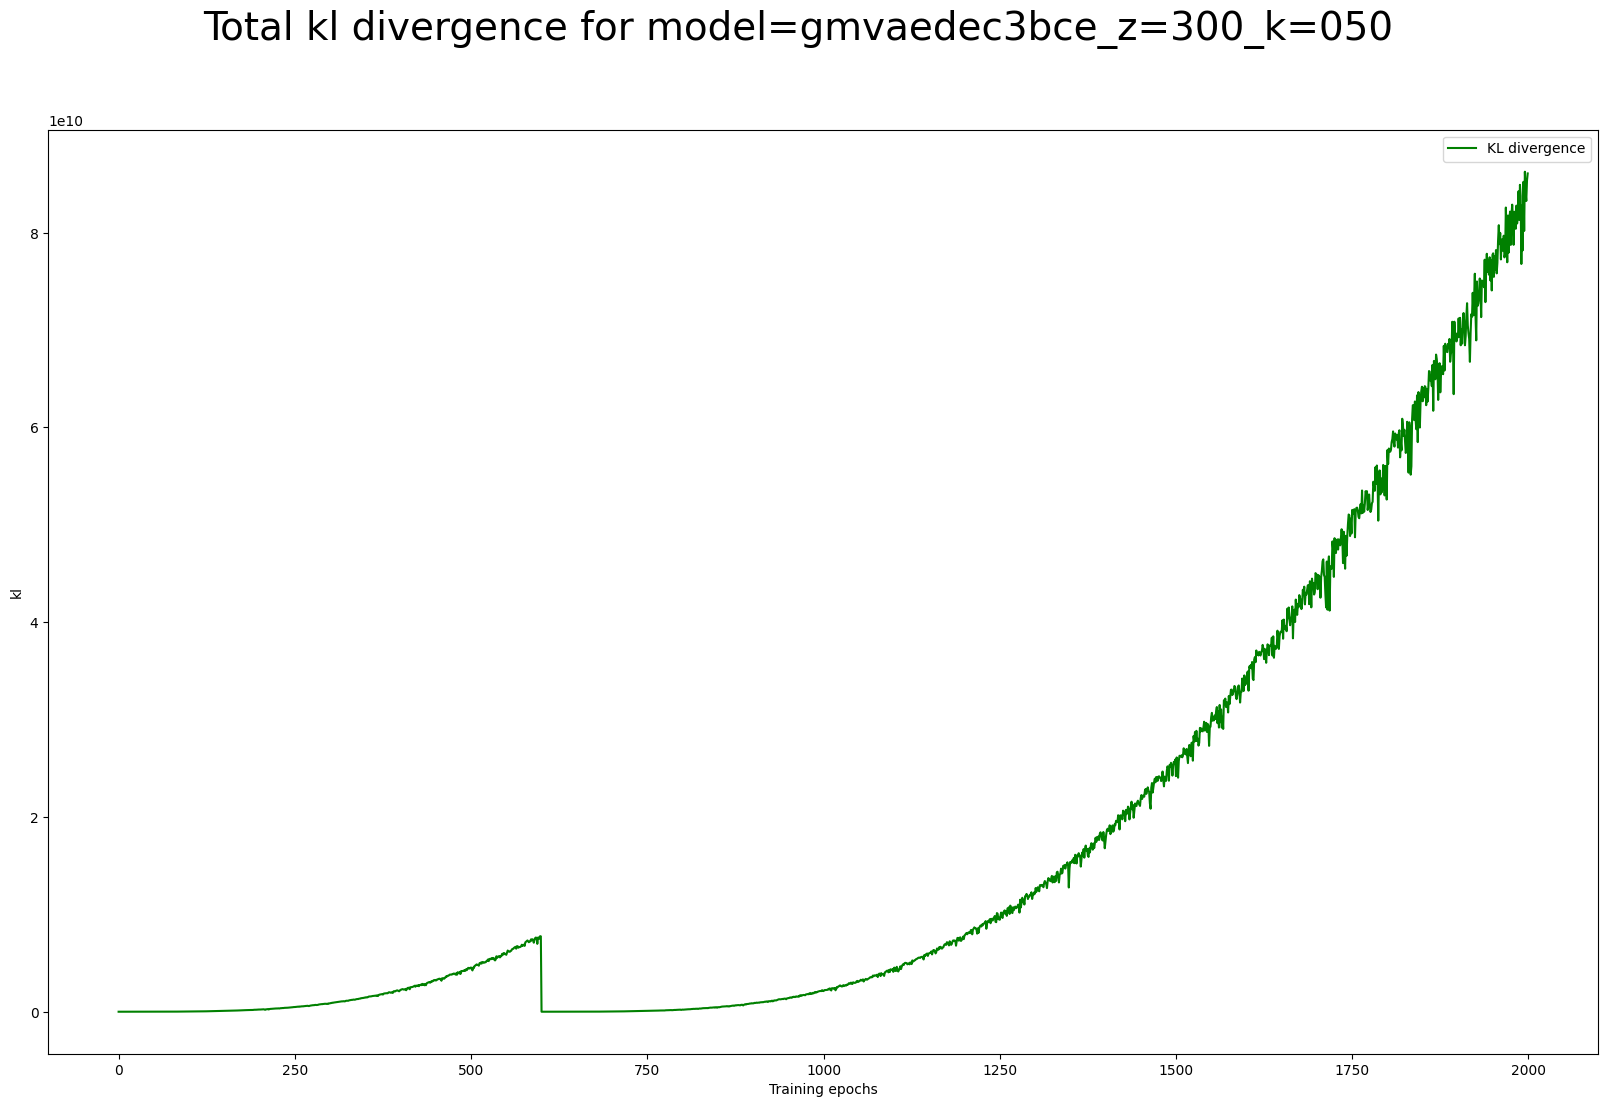

In [59]:
plot_arrays(rec=rec_1, loss=loss_1, kl=kl_1, model_name=model_1_name)

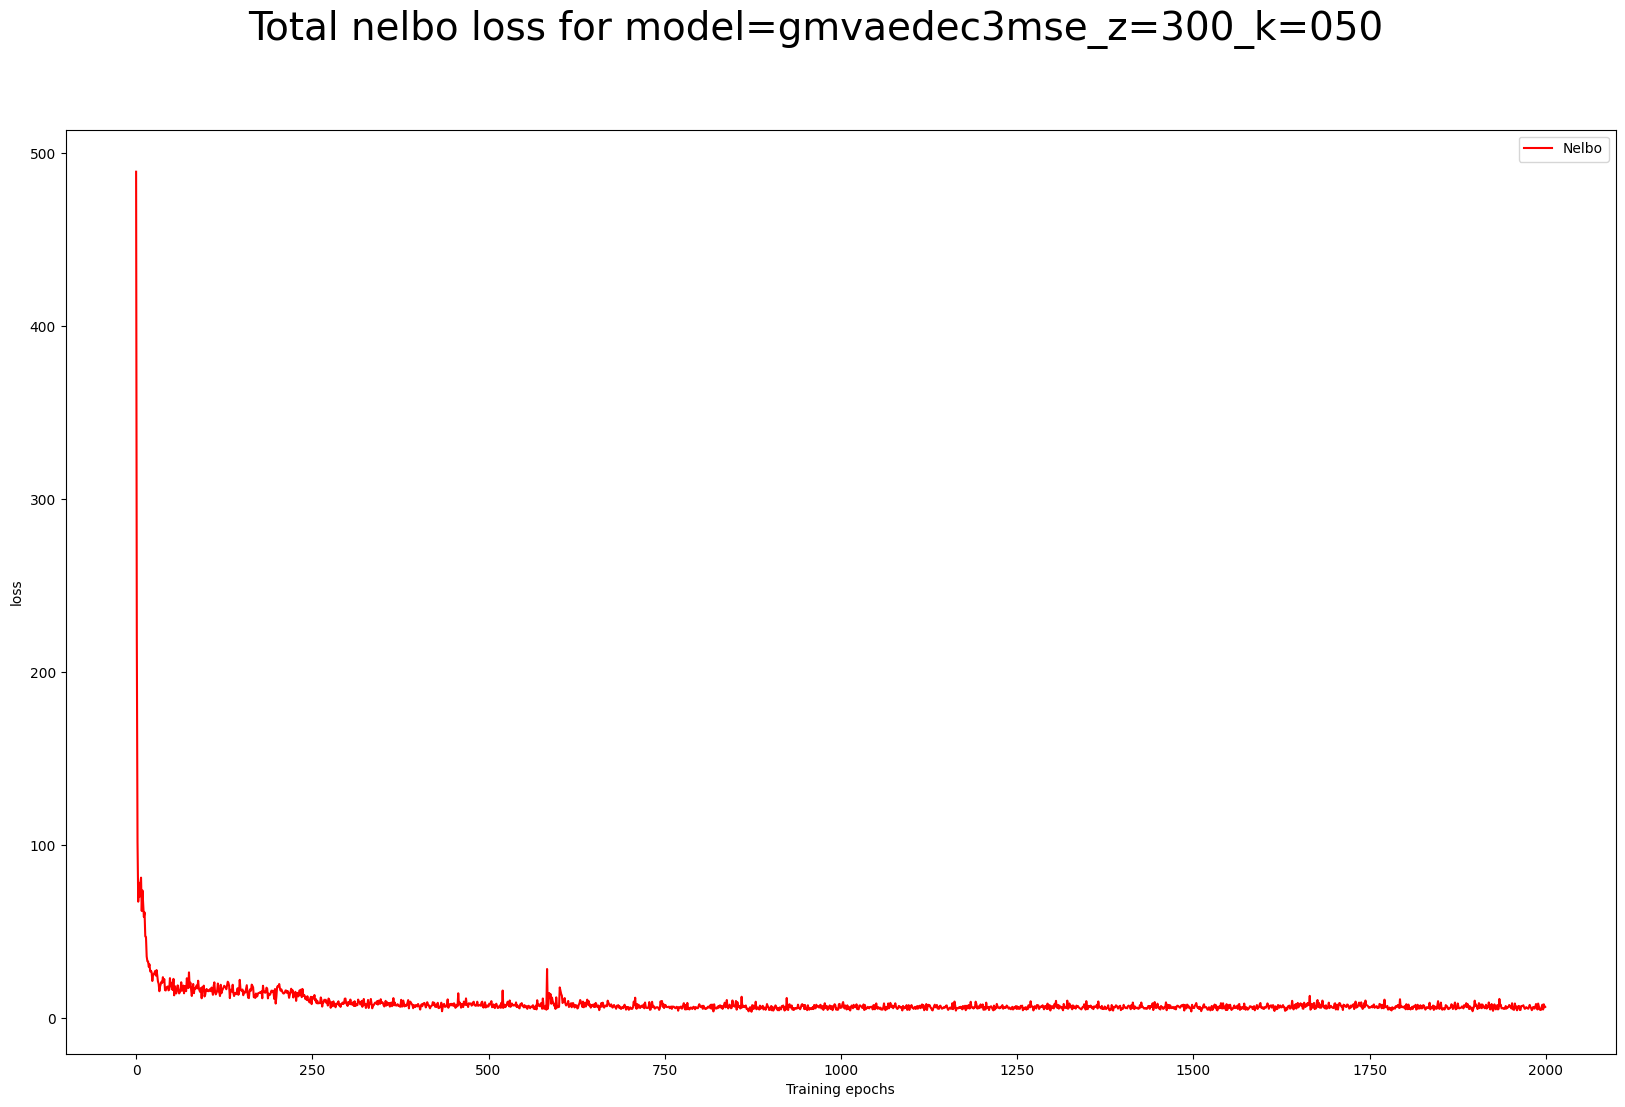

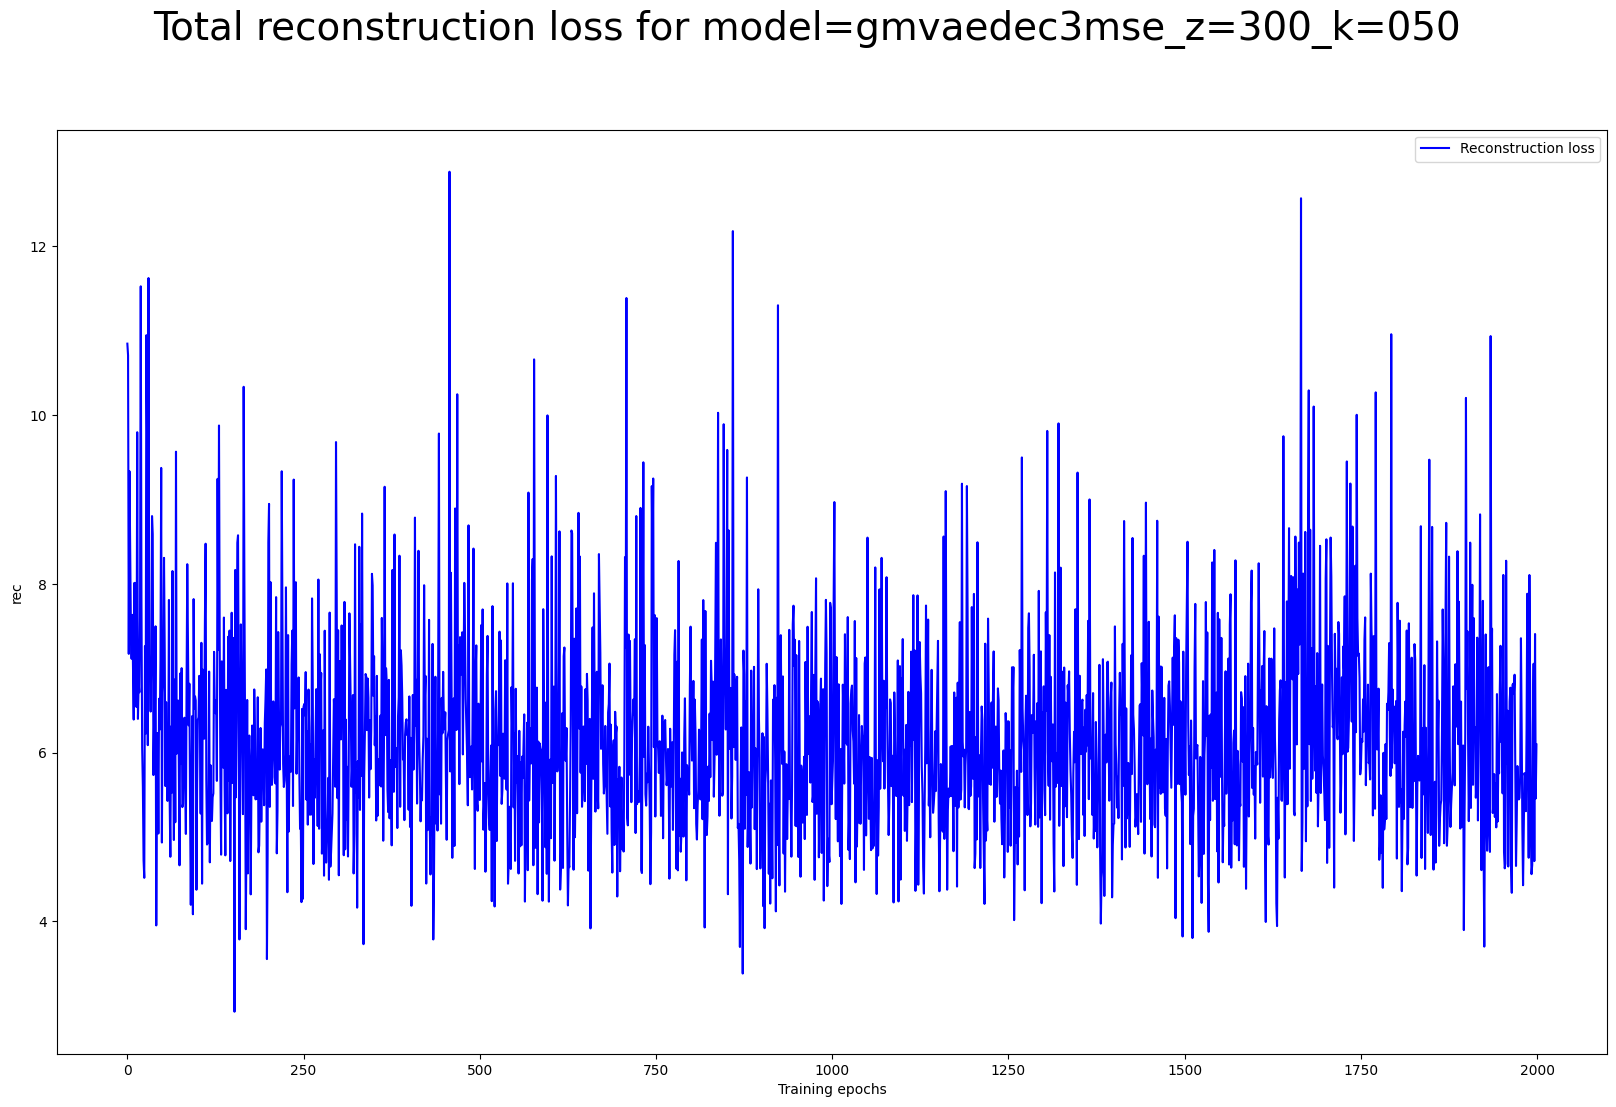

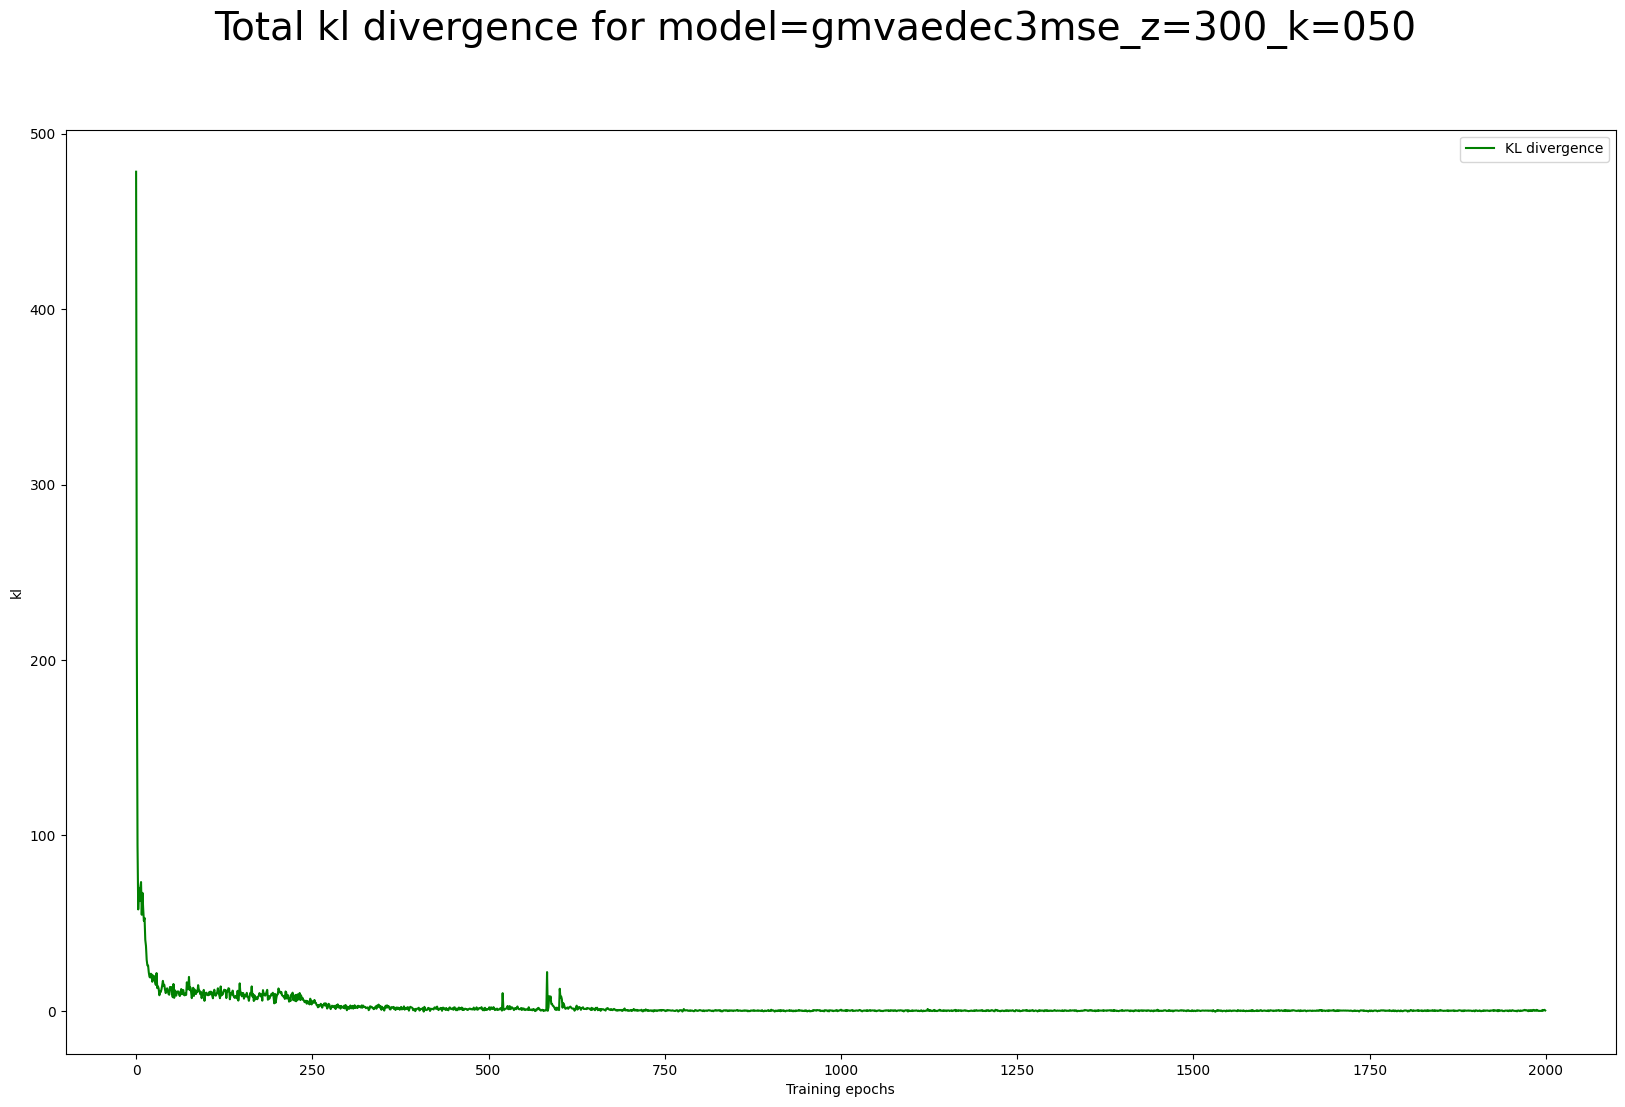

In [64]:
plot_arrays(rec=rec_2, loss=loss_2, kl=kl_2, model_name=model_2_name)